# Blue Mountains Analysis

## Prepatory work

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import GridSpec
import seaborn as sns
import mpld3
import numpy as np
import pandas as pd
import os, sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
sns.set_context("poster", font_scale=1.3)

import missingno as msno
import pandas_profiling

#import hdbscan
from sklearn.datasets import make_blobs
import time

#import bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.sampledata.iris import flowers


In [3]:
#bring in table containing initial values (cond table)
initial = pd.read_excel(open('data/initial.xlsx', 'rb'), sheetname='combo')

In [4]:
#show first 5 lines of dataframe
initial.head(n=5)

,biosum_cond_id,biosum_plot_id,invyr,condid,condprop,landclcd,fortypcd,ground_land_class_pnw,owncd,owngrpcd,...,fvs_filename,idb_cond_id,idb_plot_id,cn,biosum_status_cd,Surf_Flame_Sev,PTorch_Sev,Pot_Smoke_Sev,MortVolPct,Hazard
0,1200541050605900802440001,120054105060590080244000,2005,1,0.762815,1,201,120,46,40,...,41802441.fvs,NaN,NaN,12779657010497,1,1.846341,0.000007,0.110441,14.891304,0
1,1200541050605900802440002,120054105060590080244000,2005,2,0.254272,1,221,120,46,40,...,41802442.fvs,NaN,NaN,12779659010497,1,4.614426,0.002158,0.056354,34.412955,2
2,1200541050606300548980001,120054105060630054898000,2005,1,1.033165,1,201,120,46,40,...,41548981.fvs,NaN,NaN,12788045010497,1,1.842929,0.072967,0.119163,18.579686,0
3,1200541050606300705210001,120054105060630070521000,2005,1,1.060783,1,221,120,46,40,...,41705211.fvs,NaN,NaN,12791905010497,1,4.106618,0.000002,0.073548,13.390601,1
4,1201041060100100764700001,120104106010010076470000,2010,1,1.033271,1,267,120,11,10,...,41764701.fvs,NaN,NaN,15122412010497,1,2.382581,0.866667,0.096699,7.913669,1


# How many forested acres are currently at high fire risk (by landowner class)?

In [5]:
#group by owner and hazard score, display acres
groupby_object = initial[['owngrpcd', 'Hazard', 'acres']].groupby(['owngrpcd', 'Hazard'])

In [6]:
#calculate the sum of acres, by ownergroup and hazard score, for intial conditions, also provide a coont. 
initial_sum = groupby_object.agg('sum')\
                .rename(columns = lambda x: x + ' sum')\
                .join(pd.DataFrame(groupby_object.size(), 
                                      columns=['counts']))\
                .reset_index()
                
print(initial_sum)

   owngrpcd  Hazard      acres sum  counts
0        10       0  240773.187214     145
1        10       1  420219.399649     245
2        10       2  380476.598476     225
3        10       3  302032.748655     173
4        10       4  198777.188489     109
5        40       0   94268.337795      17
6        40       1  178911.012824      33
7        40       2  209679.389684      36
8        40       3  152979.886596      24
9        40       4   91054.734578      17


Above table: by owner group, the number and percentage of acres in for each Hazard score. 

Notes: Similiar percentage of acres in each class between owner groups, surprisingly. Would have suspected that federal lands would have a higher percentage of acres in the higher hazard score groups. 

In [7]:
#sum up acres by owner group
fed=initial_sum[initial_sum["owngrpcd"]==10].sum()["acres sum"]
private=initial_sum[initial_sum["owngrpcd"]==40].sum()["acres sum"]
total_acres=fed + private

print(fed)
print(private)
print(total_acres)

1542279.12248
726893.361477
2269172.48396


Acre totals (no filtering) by owner group:
* **Fed:** 1,542,279
* **Private:** 726,893
* **Total acres:** 2,269,172

In [8]:
#find percentage of acres in each hazard class by owner group
initial_sum['percent']=np.NaN
initial_sum['percent'][initial_sum.owngrpcd==10]=(initial_sum['acres sum']/fed)*100
initial_sum['percent'][initial_sum.owngrpcd==40]=(initial_sum['acres sum']/private)*100
print(initial_sum)

   owngrpcd  Hazard      acres sum  counts    percent
0        10       0  240773.187214     145  15.611518
1        10       1  420219.399649     245  27.246650
2        10       2  380476.598476     225  24.669763
3        10       3  302032.748655     173  19.583534
4        10       4  198777.188489     109  12.888535
5        40       0   94268.337795      17  12.968661
6        40       1  178911.012824      33  24.613103
7        40       2  209679.389684      36  28.845963
8        40       3  152979.886596      24  21.045712
9        40       4   91054.734578      17  12.526560


In [9]:
#create bar chart of hazard score of initial conditions by ownergroup 

from bokeh.charts import Bar, output_file, show
from bokeh.sampledata.autompg import autompg as df


p = Bar(initial, label='Hazard', values='acres', agg='sum', group='owngrpcd', legend='top_right')

p.left[0].formatter.use_scientific = False
output_notebook()
#output_file("barInital.html")
show(p)

Loading BokehJS ...

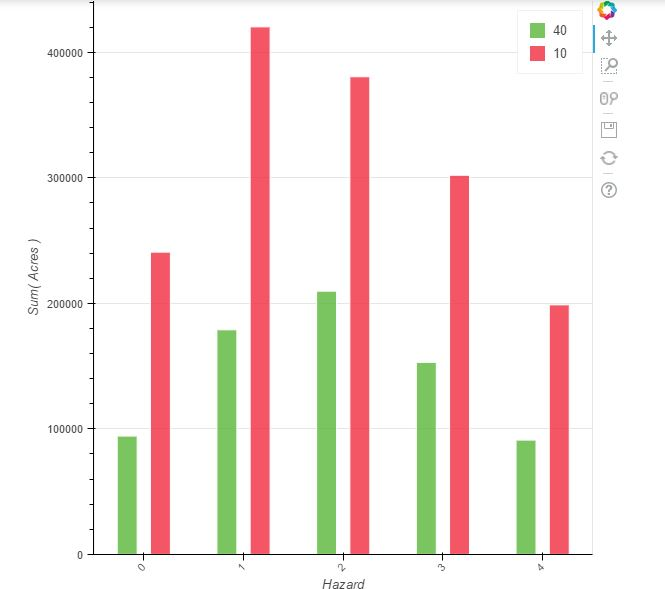

In [10]:
#For some reason the Bokeh plot is not showing up on git, so screenshot!
from IPython.display import Image
Image("img/barPlot1.jpg")

Figure: Sum of acres initially in each Hazard class by ownergroup class.

In [11]:
#create bar chart of hazard score (percents) of initial conditions by ownergroup 

pp = Bar(initial_sum, label='Hazard', values='percent', agg='sum', group='owngrpcd', legend='top_right')

pp.left[0].formatter.use_scientific = False
output_notebook()
#output_file("barInitalP.html")
show(pp)

Loading BokehJS ...

Figure: Percentage of acres in each Hazard class by ownergroup.  (Percentage of ownergroup acres, not total acres.)

#  What is treatment popularity [acres picked for each treatment] (when cost is no object, and only seeking to maximize the multi-point score described below, or the multi-point score difference from grow only)?

In [17]:
#read in the compile_Effective table (which is the cycle1_best_rx_summary from CORE ANALYSIS, not based on NET REV)
w_nNR = pd.read_excel(open('data/weighted_noNR.xlsx', 'rb'), sheetname='cycle1_best_rx_summary', lowmemory=False)


In [18]:
#display top 5 lines of table
w_nNR.head(n=5)

,biosum_cond_id,rx,acres,owngrpcd,optimization_value,tiebreaker_value,rx_intensity
0,1200641010600100555380001,107,1785.714940,10,-0.269365,2.884617,NaN
1,1200641010600100590350001,208,1810.314028,10,-0.152049,3.428965,NaN
2,1200641010600100837040001,117,2004.376193,10,-0.009741,3.797637,NaN
3,1200641010600100884810001,202,1831.523952,10,-0.125113,3.141328,NaN
4,1200641010602300587140001,202,1954.063158,10,-0.385157,2.921652,NaN


In [19]:
#group by owner and hazard score, display acres
groupby_w = w_nNR[['owngrpcd', 'rx', 'acres']].groupby(['owngrpcd', 'rx'])


In [20]:
#calculate the sum of acres, by ownergroup and hazard score, for intial conditions, also provide a count. 
w_nNR_sum = groupby_w.agg('sum')\
                .rename(columns = lambda x: x + ' sum')\
                .join(pd.DataFrame(groupby_w.size(), 
                                      columns=['counts']))\
                .reset_index()

#print the first five lines of the new table
w_nNR_sum.head(n=5)

,owngrpcd,rx,acres sum,counts
0,10,100,10029.068087,5
1,10,101,6772.751526,4
2,10,102,1880.994122,1
3,10,103,4101.026510,2
4,10,104,9347.192679,5


In [21]:
#find percentage of acres treated by each rx by owner group
#NOTE: percentages are of owner group acre totals, NOT of combined total acres
w_nNR_sum['percent']=np.NaN
w_nNR_sum['percent'][w_nNR_sum.owngrpcd==10]=(w_nNR_sum['acres sum']/fed)*100
w_nNR_sum['percent'][w_nNR_sum.owngrpcd==40]=(w_nNR_sum['acres sum']/private)*100
w_nNR_sum.head(n=5)

,owngrpcd,rx,acres sum,counts,percent
0,10,100,10029.068087,5,0.650276
1,10,101,6772.751526,4,0.439139
2,10,102,1880.994122,1,0.121962
3,10,103,4101.026510,2,0.265907
4,10,104,9347.192679,5,0.606064


Dataframe **w_nNR_sum**: ownergroup, rx, sum of acres, counts, and percent of subgroup total acres, that COULD be treated effectively by at least one treatment. 

In [22]:
#total up acres that are able to be treated by an rx by ownertype
fed_treat=w_nNR_sum[w_nNR_sum["owngrpcd"]==10].sum()["acres sum"]
private_treat=w_nNR_sum[w_nNR_sum["owngrpcd"]==40].sum()["acres sum"]

In [23]:
print(fed_treat)
print(private_treat)

491121.517036
170582.22113


Total acres that could be treated by any rx:
* **Federal**: 491,121
* **Private**: 170,582

In [24]:
#total up percent of acres that are able to be treated by an rx by ownertype
fed_treatP=w_nNR_sum[w_nNR_sum["owngrpcd"]==10].sum()["percent"]
private_treatP=w_nNR_sum[w_nNR_sum["owngrpcd"]==40].sum()["percent"]

In [25]:
print(fed_treatP)
print(private_treatP)

31.8438802598
23.4672966037


**31% of federal acres** could be effectively treated by one or more of the treatment packages. 

**23% of private acres** coule be effectively treated by one or more of the treatment packages.  

This is not considering net revenue.  Cost is not an issue. (Ha!)

In [26]:
#add acres that could NOT be treated by any RX to the table
#calculate fed acres not treated
fed_notTreated=fed-fed_treat

#calculate private acres not treated
private_notTreated=private-private_treat

#calculate fed acres not treated PERCENT
fed_notTreatedP=100-fed_treatP

#calculate private acres not treated PERCENT
private_notTreatedP=100-private_treatP

#append to fed and private NON TREATED acres to the dataframe
fedrow = [10, "000", fed_notTreated, 0, fed_notTreatedP]

w_nNR_sum.loc[len(w_nNR_sum)] = fedrow

# print values
print(fed_notTreated)
print(fed_notTreatedP)
print(private_notTreated)
print(private_notTreatedP)

1051157.60545
68.1561197402
556311.140347
76.5327033963


Total acres that could **NOT** be treated by any rx:
* **Federal**: 1,051,157 (68%)
* **Private**: 556,311 (76%)

Notes: Quite a large majority.  Remember, this is looking at the weighted average over 40 years (actually 31).  
To do: Look into how different this looks when only considering First Entry Hazard Scores. 

## Quick aside, how many acres can be effectively treated using the only First Entry pre/post values, rather than weighted average vs. grow only.  

In [198]:
#read in the compile_Effective_FE table (which is the cycle1_best_rx_summary from CORE ANALYSIS First Entry scenario, not based on NET REV)
fe_nNR = pd.read_excel(open('data/compile_Effective_FE.xlsx', 'rb'), sheetname='cycle1_best_rx_summary', lowmemory=False)


In [199]:
#display top 5 lines of table
fe_nNR.head(n=5)

,biosum_cond_id,rx,acres,owngrpcd,optimization_value,tiebreaker_value,rx_intensity
0,1200641010600100555380001,200,1785.7,10,0.9,1006.4,nan
1,1200641010600100590350001,100,1810.3,10,0.0,314.3,nan
2,1200641010600100768280001,110,2004.4,10,0.8,544.4,nan
3,1200641010600100875990001,210,2004.4,10,0.0,-92.3,nan
4,1200641010600100884810001,200,1831.5,10,0.0,716.3,nan


In [200]:
#group by owner and hazard score, display acres
groupby_w = fe_nNR[['owngrpcd', 'rx', 'acres']].groupby(['owngrpcd', 'rx'])


In [201]:
#calculate the sum of acres, by ownergroup and hazard score, for intial conditions, also provide a count. 
fe_nNR = groupby_w.agg('sum')\
                .rename(columns = lambda x: x + ' sum')\
                .join(pd.DataFrame(groupby_w.size(), 
                                      columns=['counts']))\
                .reset_index()

#print the first five lines of the new table
fe_nNR.head(n=5)

,owngrpcd,rx,acres sum,counts
0,10,100,122342.5,70
1,10,101,36250.6,22
2,10,102,27150.3,13
3,10,103,10457.7,5
4,10,104,89491.7,43


In [202]:
#find percentage of acres treated by each rx by owner group
#NOTE: percentages are of owner group acre totals, NOT of combined total acres
fe_nNR['percent']=np.NaN
fe_nNR['percent'][fe_nNR.owngrpcd==10]=(fe_nNR['acres sum']/fed)*100
fe_nNR['percent'][fe_nNR.owngrpcd==40]=(fe_nNR['acres sum']/private)*100
fe_nNR.head(n=5)

,owngrpcd,rx,acres sum,counts,percent
0,10,100,122342.5,70,7.9
1,10,101,36250.6,22,2.4
2,10,102,27150.3,13,1.8
3,10,103,10457.7,5,0.7
4,10,104,89491.7,43,5.8


Dataframe **fe_nNR**: ownergroup, rx, sum of acres, counts, and percent of subgroup total acres, that COULD be treated effectively by at least one treatment. 

In [203]:
#total up acres that are able to be treated by an rx by ownertype
fed_treat2=fe_nNR[fe_nNR["owngrpcd"]==10].sum()["acres sum"]
private_treat2=fe_nNR[fe_nNR["owngrpcd"]==40].sum()["acres sum"]

In [204]:
print(fed_treat2)
print(private_treat2)

731372.431163
315468.386204


Total acres that could be treated by any rx in First Entry scenario:
* **Federal**: 731,372
* **Private**: 315,468

In [205]:
#total up percent of acres that are able to be treated by an rx by ownertype
fed_treat2P=fe_nNR[fe_nNR["owngrpcd"]==10].sum()["percent"]
private_treat2P=fe_nNR[fe_nNR["owngrpcd"]==40].sum()["percent"]

In [206]:
print(fed_treat2P)
print(private_treat2P)

47.4215348247
43.3995415178


**47% of federal acres** could be effectively treated by one or more of the treatment packages. 

**43% of private acres** coule be effectively treated by one or more of the treatment packages.  


## Back to treatment populatity in the weigthed ave. vs. grow only scenario

In [26]:
#add acres that could NOT be treated by any RX to the table
#calculate fed acres not treated
fed_notTreated=fed-fed_treat

#calculate private acres not treated
private_notTreated=private-private_treat

#calculate fed acres not treated PERCENT
fed_notTreatedP=100-fed_treatP

#calculate private acres not treated PERCENT
private_notTreatedP=100-private_treatP

#append to fed and private NON TREATED acres to the dataframe
fedrow = [10, "000", fed_notTreated, 0, fed_notTreatedP]

w_nNR_sum.loc[len(w_nNR_sum)] = fedrow

# print values
print(fed_notTreated)
print(fed_notTreatedP)
print(private_notTreated)
print(private_notTreatedP)

1051157.60545
68.1561197402
556311.140347
76.5327033963


In [27]:
# add private row to table as well. 
privaterow = [40, "000", private_notTreated, 0, private_notTreatedP]
w_nNR_sum.loc[len(w_nNR_sum)] = privaterow
w_nNR_sum.head(n=5)

,owngrpcd,rx,acres sum,counts,percent
0,10,100,10029.068087,5,0.650276
1,10,101,6772.751526,4,0.439139
2,10,102,1880.994122,1,0.121962
3,10,103,4101.026510,2,0.265907
4,10,104,9347.192679,5,0.606064


In [28]:
#try to make a graph
from bokeh.charts import Bar, output_file, show

w_nNR_sum.owngrpcd = w_nNR_sum.owngrpcd.astype(str)
w_nNR_sum.rx = w_nNR_sum.rx.astype(str)

ch = Bar(w_nNR_sum, label='rx', values='acres sum', stack='owngrpcd', legend='top_right')
ch.left[0].formatter.use_scientific = False
output_notebook()
#output_file("bar1.html")
show(ch)


Loading BokehJS ...

Well that doesn't say much, except that "no effective treatement" is the overpowering winner. Let's try it without the no-treat.

In [115]:
#drop rx=000 records and create new table
w_nNR_sumT= w_nNR_sum[w_nNR_sum.rx != '000']

#convert data types to 'str'
w_nNR_sumT.owngrpcd = w_nNR_sumT.owngrpcd.astype(str)
w_nNR_sumT.rx = w_nNR_sumT.rx.astype(str)

#create bar graph
cy = Bar(w_nNR_sumT, label='rx', values='acres sum', stack='owngrpcd', legend='top_right')

output_notebook()
#output_file("bar2.html")
show(cy)

Loading BokehJS ...

Figure: 'Best' treatment (not considering net revenue) by owner class. 

Notes: top packages include:
* **208** - Thin from below to BA 40 (entry threshold 85), 5-21 DBH, prescribed burn, WT harvest
* **200** - Thin from below to BA 40 (entry trheshold 85), 5-21 DBH, prescribed burn, WT harvest, target ABGR
* **110** - Thin across diameter range to BA 25 (entry threshold 50), 0-21, l&s, WT harvest, target ABGR


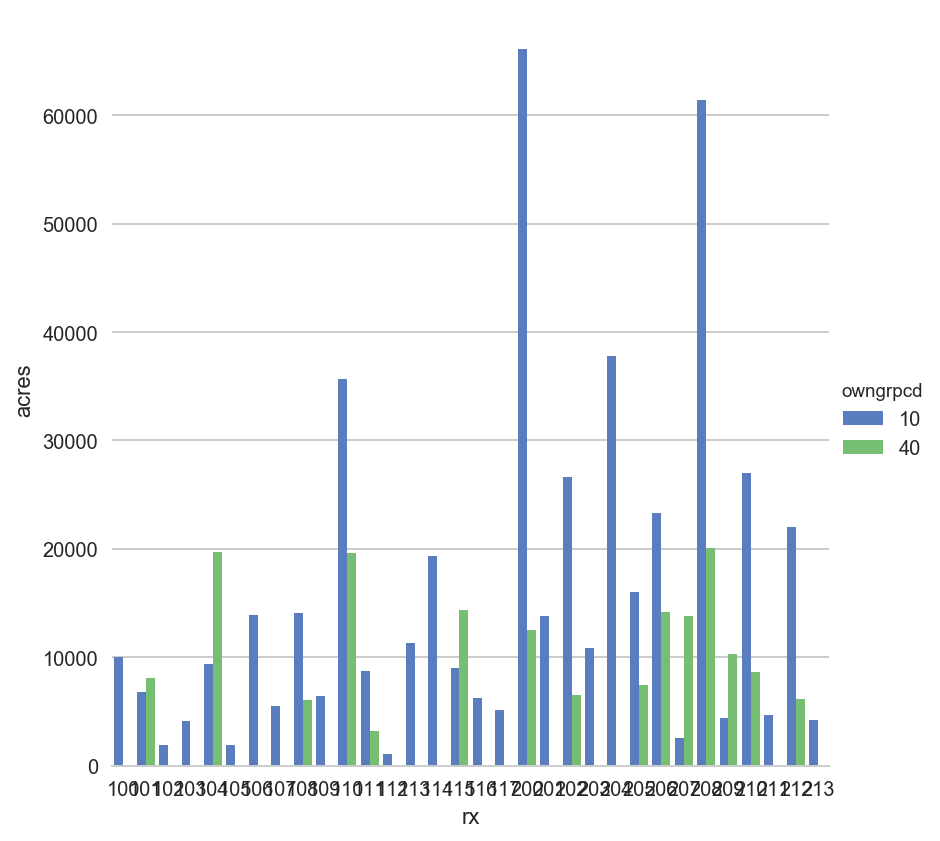

In [30]:
#try a different plot for fun. 
sns.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
#g = sns.factorplot(x="class", y="survived", hue="sex", data=titanic,
 #                  size=6, kind="bar", palette="muted")

cy = sns.factorplot(x='rx', y='acres sum', hue='owngrpcd', data=w_nNR_sumT, 
                   size=6, kind='bar', palette='muted')

cy.despine(left=True)
cy.set_ylabels("acres")

I will have to work on this one. :)


#  What is treatment popularity when NR must be positive? 

In [31]:
#read in the compile_Effective when NR must be greater than 0.
w_NR = pd.read_excel(open('data/weighted_NR.xlsx', 'rb'), sheetname='cycle1_best_rx_summary', lowmemory=False)

In [32]:
#display top 5 lines of table
w_NR.head(n=5)

,biosum_cond_id,rx,acres,owngrpcd,optimization_value,tiebreaker_value,rx_intensity
0,1200641010600100555380001,107,1785.714940,10,-0.269365,435.370412,NaN
1,1200641010600100590350001,204,1810.314028,10,-0.152049,1206.189785,NaN
2,1200641010600100837040001,100,2004.376193,10,0.041720,646.674194,NaN
3,1200641010600100884810001,206,1831.523952,10,-0.053175,1076.553422,NaN
4,1200641010602300587140001,108,1954.063158,10,-0.285712,637.793497,NaN


In [33]:
#group by owner and hazard score, display acres
groupby_wNR = w_NR[['owngrpcd', 'rx', 'acres']].groupby(['owngrpcd', 'rx'])

In [34]:
#calculate the sum of acres, by ownergroup and hazard score, for intial conditions, also provide a coont. 
w_NR_sum = groupby_wNR.agg('sum')\
                .rename(columns = lambda x: x + ' sum')\
                .join(pd.DataFrame(groupby_wNR.size(), 
                                      columns=['counts']))\
                .reset_index()
                
w_NR_sum.head(n=5)

,owngrpcd,rx,acres sum,counts
0,10,100,23851.887740,12
1,10,101,5404.868148,3
2,10,102,1822.158066,1
3,10,103,2458.383241,1
4,10,104,22275.923621,13


In [35]:
#find percentage of acres treated by each rx by owner group
w_NR_sum['percent']=np.NaN
w_NR_sum['percent'][w_NR_sum.owngrpcd==10]=(w_NR_sum['acres sum']/fed)*100
w_NR_sum['percent'][w_NR_sum.owngrpcd==40]=(w_NR_sum['acres sum']/private)*100
w_NR_sum.head(n=5)

,owngrpcd,rx,acres sum,counts,percent
0,10,100,23851.887740,12,1.546535
1,10,101,5404.868148,3,0.350447
2,10,102,1822.158066,1,0.118147
3,10,103,2458.383241,1,0.159399
4,10,104,22275.923621,13,1.444351


In [36]:
#total up acres that are able to be treated by an rx by ownertype (with net rev > 0)
fed_treatNR=w_NR_sum[w_NR_sum["owngrpcd"]==10].sum()["acres sum"]
private_treatNR=w_NR_sum[w_NR_sum["owngrpcd"]==40].sum()["acres sum"]

In [37]:
print(fed_treatNR)
print(private_treatNR)

402223.377347
126384.139254


In [38]:
#total up percent of acres that are able to be treated by an rx by ownertype (with net rev > -200)
fed_treatPnr=w_NR_sum[w_NR_sum["owngrpcd"]==10].sum()["percent"]
private_treatPnr=w_NR_sum[w_NR_sum["owngrpcd"]==40].sum()["percent"]

In [39]:
print(fed_treatPnr)
print(private_treatPnr)

26.0798043287
17.3868886348


When NET REV must be greater than 0, the number of acres that can be effectively treated drops. 
* **Federal**: 402,223 (26%) ((down from 31%))
* **Private**: 126,384 (17%) ((down from 23%))

In [40]:
#convert data types to 'str'
w_NR_sum.owngrpcd = w_NR_sum.owngrpcd.astype(str)
w_NR_sum.rx = w_NR_sum.rx.astype(str)

#create bar graph
ct = Bar(w_NR_sum, label='rx', values='acres sum', stack='owngrpcd', legend='top_right')

output_notebook()
#output_file("bar3.html")
show(ct)

Loading BokehJS ...

Figure: 'Best' treatment when net revenue must be > 0,  by owner class. 

Notes: top packages include:
* **208** - Thin from below to BA 40 (entry threshold 85), 5-21 DBH, prescribed burn, WT harvest

Really a breakout winner.

# How many fewer acres can be effectively treated if DBH cap is 21 rather than 30? How many fewer acres can be treated if this is imposed and each acre must pay for itself? 

Create a table from the cycle1_optimization table that has everything we need in this analysis. "Opt" query in core analysis table. Will be used in future SQL. 

``` mysql
SELECT cycle1_optimization.biosum_cond_id, cycle1_optimization.rxpackage, cycle1_optimization.rx, cycle1_optimization.change_value AS ptorchChange, tiebreaker.post_variable1_value AS TIPost, cond.acres
FROM (cond INNER JOIN tiebreaker ON cond.biosum_cond_id = tiebreaker.biosum_cond_id) INNER JOIN cycle1_optimization ON (cycle1_optimization.rxcycle = tiebreaker.rxcycle) AND (cycle1_optimization.rxpackage = tiebreaker.rxpackage) AND (tiebreaker.biosum_cond_id = cycle1_optimization.biosum_cond_id);

```

In [41]:
#read in the cycle1_optimization created by SQL above from tables in core analysis
w_nNR_opt = pd.read_excel(open('data/weighted_noNR_opt.xlsx', 'rb'), sheetname='opt', lowmemory=False)

w_nNR_opt.biosum_cond_id = w_nNR_opt.biosum_cond_id.astype(str)
w_nNR_opt.rx = w_nNR_opt.rx.astype(str)
w_nNR_opt.rxpackage = w_nNR_opt.rxpackage.astype(str)

In [42]:
# list of rx values that coorespond to 21 and 30 inch DBH caps
cap21 = ('100', '101', '102', '103', '200', '201', '202', '203')

cap30 = ('104', '105', '106', '107', '204', '205', '206', '207')

In [43]:
#filter optimiztion table by cap21 
w_nNR_21=w_nNR_opt[w_nNR_opt['rx'].isin(cap21)]

print(w_nNR_21.shape)
w_nNR_21.head(n=5)


(1019, 7)


,biosum_cond_id,rxpackage,rx,ptorchChange,TIPost,acres,max_nr_dpa
0,1200641010600100555380001,3,102,-0.243312,2.524336,1785.714940,750.930713
1,1200641010600100555380001,4,103,-0.268314,3.427964,1785.714940,394.526496
6,1200641010600100555380001,21,202,-0.247488,2.523612,1785.714940,653.447023
7,1200641010600100555380001,22,203,-0.267133,3.415907,1785.714940,337.782536
12,1200641010600100590350001,1,100,-0.147969,3.219303,1810.314028,314.251971


In [44]:
#Optimize by stand, max reduction in PTorch, create new table w_nNR_21opt

from pandasql import *

pysqldf = lambda q: sqldf(q, globals())

q  = """
SELECT *, MIN(ptorchChange) FROM w_nNR_21 WHERE ptorchChange < 0 GROUP BY biosum_cond_id;
"""
w_nNR_21opt = pysqldf(q)

print(w_nNR_21opt.shape)
w_nNR_21opt.biosum_cond_id = w_nNR_21opt.biosum_cond_id.astype(object)
w_nNR_21opt.head(n=5)

(243, 8)


,biosum_cond_id,rxpackage,rx,ptorchChange,TIPost,acres,max_nr_dpa,MIN(ptorchChange)
0,1200641010600100555380001,4,103,-0.268314,3.427964,1785.714940,394.526496,-0.268314
1,1200641010600100590350001,19,200,-0.152049,3.428965,1810.314028,-273.926855,-0.152049
2,1200641010600100884810001,21,202,-0.125113,3.141328,1831.523952,-2340.150465,-0.125113
3,1200641010602300587140001,21,202,-0.385157,2.921652,1954.063158,-925.186088,-0.385157
4,1200641010602300634230001,19,200,-0.309149,4.359630,1954.063158,162.254118,-0.309149


In [45]:
#Run tiebreaker on 21 optimization for final table w_nNR_21tie
q2  = """
SELECT *, MAX(TIPost) FROM w_nNR_21opt GROUP BY biosum_cond_id;
"""
w_nNR_21tie = pysqldf(q2)

w_nNR_21tie.biosum_cond_id = w_nNR_21tie.biosum_cond_id.astype(object)

print(w_nNR_21tie.shape)
w_nNR_21tie.head(n=5)

(243, 9)


,biosum_cond_id,rxpackage,rx,ptorchChange,TIPost,acres,max_nr_dpa,MIN(ptorchChange),MAX(TIPost)
0,1200641010600100555380001,4,103,-0.268314,3.427964,1785.714940,394.526496,-0.268314,3.427964
1,1200641010600100590350001,19,200,-0.152049,3.428965,1810.314028,-273.926855,-0.152049,3.428965
2,1200641010600100884810001,21,202,-0.125113,3.141328,1831.523952,-2340.150465,-0.125113,3.141328
3,1200641010602300587140001,21,202,-0.385157,2.921652,1954.063158,-925.186088,-0.385157,2.921652
4,1200641010602300634230001,19,200,-0.309149,4.359630,1954.063158,162.254118,-0.309149,4.359630


In [46]:
#Sum up the number of acres that can be treated with a 21" DBH cap.      
treat21=w_nNR_21tie.sum()["acres"]
print(treat21)

491138.635001


Number of acres that can be treated by one or more packages with a 21"DBH cap: **491,138**. 

## Now do the same thing with 30 cap, how do they compare?

In [47]:
#filter optimiztion table by cap21 
w_nNR_30=w_nNR_opt[w_nNR_opt['rx'].isin(cap30)]

print(w_nNR_30.shape)
w_nNR_30.head(n=5)


(953, 7)


,biosum_cond_id,rxpackage,rx,ptorchChange,TIPost,acres,max_nr_dpa
4,1200641010600100555380001,11,106,-0.093487,3.181731,1785.714940,580.519753
5,1200641010600100555380001,12,107,-0.269365,2.884617,1785.714940,435.370412
8,1200641010600100555380001,25,206,-0.105917,3.205477,1785.714940,471.849578
9,1200641010600100555380001,26,207,-0.267133,3.415907,1785.714940,337.782536
13,1200641010600100590350001,9,104,-0.148936,3.217302,1810.314028,203.282665


In [48]:
#Optimize by stand, max reduction in PTorch, create new table w_nNR_21opt

from pandasql import *

pysqldf = lambda q: sqldf(q, globals())

q3  = """
SELECT *, MIN(ptorchChange) FROM w_nNR_30 WHERE ptorchChange < 0 GROUP BY biosum_cond_id;
"""
w_nNR_30opt = pysqldf(q3)

print(w_nNR_30opt.shape)
w_nNR_30opt.biosum_cond_id = w_nNR_30opt.biosum_cond_id.astype(object)
w_nNR_30opt.head(n=5)

(246, 8)


,biosum_cond_id,rxpackage,rx,ptorchChange,TIPost,acres,max_nr_dpa,MIN(ptorchChange)
0,1200641010600100555380001,12,107,-0.269365,2.884617,1785.714940,435.370412,-0.269365
1,1200641010600100590350001,23,204,-0.152049,3.428965,1810.314028,1206.189785,-0.152049
2,1200641010600100884810001,25,206,-0.053175,2.528377,1831.523952,1076.553422,-0.053175
3,1200641010602300587140001,25,206,-0.385157,2.921652,1954.063158,-925.186088,-0.385157
4,1200641010602300634230001,23,204,-0.309149,4.359630,1954.063158,640.652023,-0.309149


In [49]:
#Run tiebreaker on 21 optimization for final table w_nNR_21tie
q4  = """
SELECT *, MAX(TIPost) FROM w_nNR_30opt GROUP BY biosum_cond_id;
"""
w_nNR_30tie = pysqldf(q4)

w_nNR_30tie.biosum_cond_id = w_nNR_30tie.biosum_cond_id.astype(object)

print(w_nNR_30tie.shape)
w_nNR_30tie.head(n=5)

(246, 9)


,biosum_cond_id,rxpackage,rx,ptorchChange,TIPost,acres,max_nr_dpa,MIN(ptorchChange),MAX(TIPost)
0,1200641010600100555380001,12,107,-0.269365,2.884617,1785.714940,435.370412,-0.269365,2.884617
1,1200641010600100590350001,23,204,-0.152049,3.428965,1810.314028,1206.189785,-0.152049,3.428965
2,1200641010600100884810001,25,206,-0.053175,2.528377,1831.523952,1076.553422,-0.053175,2.528377
3,1200641010602300587140001,25,206,-0.385157,2.921652,1954.063158,-925.186088,-0.385157,2.921652
4,1200641010602300634230001,23,204,-0.309149,4.359630,1954.063158,640.652023,-0.309149,4.359630


In [50]:
#Sum up the number of acres that can be treated with a 21" DBH cap.      
treat30=w_nNR_30tie.sum()["acres"]
print(treat30)
print (treat30-treat21)

509172.642348
18034.0073466


Number of acres that can be treated by one or more packages with a 30"DBH cap: **509,172**. 

Compare this to 491,138 when the cap is 21"DBH, a different of **18,034** acres. 

## How about when you restrict results to only acres with a NET REV > 0? 

In [51]:
#read in the cycle1_optimization created by SQL above from tables in core analysis
w_NR_opt = pd.read_excel(open('data/weighted_NR_opt.xlsx', 'rb'), sheetname='opt', lowmemory=False)

w_NR_opt.biosum_cond_id = w_NR_opt.biosum_cond_id.astype(str)
w_NR_opt.rx = w_NR_opt.rx.astype(str)
w_NR_opt.rxpackage = w_NR_opt.rxpackage.astype(str)

In [52]:
#filter optimiztion table by cap21 
w_NR_21=w_NR_opt[w_NR_opt['rx'].isin(cap21)]

print(w_NR_21.shape)
w_NR_21.head(n=5)


(579, 6)


,biosum_cond_id,rxpackage,rx,ptorchChange,TIPost,acres
0,1200641010600100555380001,3,102,-0.243312,750.930713,1785.714940
1,1200641010600100555380001,4,103,-0.268314,394.526496,1785.714940
4,1200641010600100555380001,21,202,-0.247488,653.447023,1785.714940
5,1200641010600100555380001,22,203,-0.267133,337.782536,1785.714940
8,1200641010600100590350001,1,100,-0.147969,314.251971,1810.314028


In [53]:
#Optimize by stand, max reduction in PTorch, create new table w_nNR_21opt

from pandasql import *

pysqldf = lambda q: sqldf(q, globals())

q5  = """
SELECT *, MIN(ptorchChange) FROM w_NR_21 WHERE ptorchChange < 0 GROUP BY biosum_cond_id;
"""
w_NR_21opt = pysqldf(q5)

print(w_NR_21opt.shape)
w_NR_21opt.biosum_cond_id = w_NR_21opt.biosum_cond_id.astype(object)
w_NR_21opt.head(n=5)

(161, 7)


,biosum_cond_id,rxpackage,rx,ptorchChange,TIPost,acres,MIN(ptorchChange)
0,1200641010600100555380001,4,103,-0.268314,394.526496,1785.714940,-0.268314
1,1200641010600100590350001,1,100,-0.147969,314.251971,1810.314028,-0.147969
2,1200641010602300587140001,1,100,-0.278768,607.372595,1954.063158,-0.278768
3,1200641010602300634230001,19,200,-0.309149,162.254118,1954.063158,-0.309149
4,1200641010606100621950001,1,100,-0.119441,1342.901576,1822.158066,-0.119441


In [54]:
#Run tiebreaker on 21 optimization for final table w_nNR_21tie
q6  = """
SELECT *, MAX(TIPost) FROM w_NR_21opt GROUP BY biosum_cond_id;
"""
w_NR_21tie = pysqldf(q6)

w_NR_21tie.biosum_cond_id = w_NR_21tie.biosum_cond_id.astype(object)

print(w_NR_21tie.shape)
w_NR_21tie.head(n=5)

(161, 8)


,biosum_cond_id,rxpackage,rx,ptorchChange,TIPost,acres,MIN(ptorchChange),MAX(TIPost)
0,1200641010600100555380001,4,103,-0.268314,394.526496,1785.714940,-0.268314,394.526496
1,1200641010600100590350001,1,100,-0.147969,314.251971,1810.314028,-0.147969,314.251971
2,1200641010602300587140001,1,100,-0.278768,607.372595,1954.063158,-0.278768,607.372595
3,1200641010602300634230001,19,200,-0.309149,162.254118,1954.063158,-0.309149,162.254118
4,1200641010606100621950001,1,100,-0.119441,1342.901576,1822.158066,-0.119441,1342.901576


In [55]:
#Sum up the number of acres that can be treated with a 21" DBH cap.      
treat21nr=w_NR_21tie.sum()["acres"]
print(treat21nr)

318924.835465


When net rev must be positive, the number of acres that can be treated with one or more rx with a cap of 21"DBH: **318,924**

## Now do the same thing with 30 cap, how do they compare?

In [56]:
#filter optimiztion table by cap21 
w_NR_30=w_NR_opt[w_NR_opt['rx'].isin(cap30)]

print(w_NR_30.shape)
w_NR_30.head(n=5)


(693, 6)


,biosum_cond_id,rxpackage,rx,ptorchChange,TIPost,acres
2,1200641010600100555380001,11,106,-0.093487,580.519753,1785.714940
3,1200641010600100555380001,12,107,-0.269365,435.370412,1785.714940
6,1200641010600100555380001,25,206,-0.105917,471.849578,1785.714940
7,1200641010600100555380001,26,207,-0.267133,337.782536,1785.714940
9,1200641010600100590350001,9,104,-0.148936,203.282665,1810.314028


In [57]:
#Optimize by stand, max reduction in PTorch, create new table w_NR_21opt

from pandasql import *

pysqldf = lambda q: sqldf(q, globals())

q7  = """
SELECT *, MIN(ptorchChange) FROM w_NR_30 WHERE ptorchChange < 0 GROUP BY biosum_cond_id;
"""
w_NR_30opt = pysqldf(q7)

print(w_NR_30opt.shape)
w_NR_30opt.biosum_cond_id = w_NR_30opt.biosum_cond_id.astype(object)
w_NR_30opt.head(n=5)

(204, 7)


,biosum_cond_id,rxpackage,rx,ptorchChange,TIPost,acres,MIN(ptorchChange)
0,1200641010600100555380001,12,107,-0.269365,435.370412,1785.714940,-0.269365
1,1200641010600100590350001,23,204,-0.152049,1206.189785,1810.314028,-0.152049
2,1200641010600100884810001,25,206,-0.053175,1076.553422,1831.523952,-0.053175
3,1200641010602300587140001,9,104,-0.277233,816.704429,1954.063158,-0.277233
4,1200641010602300634230001,23,204,-0.309149,640.652023,1954.063158,-0.309149


In [58]:
#Run tiebreaker on 21 optimization for final table w_NR_21tie
q8  = """
SELECT *, MAX(TIPost) FROM w_NR_30opt GROUP BY biosum_cond_id;
"""
w_NR_30tie = pysqldf(q8)

w_NR_30tie.biosum_cond_id = w_NR_30tie.biosum_cond_id.astype(object)

print(w_NR_30tie.shape)
w_NR_30tie.head(n=5)

(204, 8)


,biosum_cond_id,rxpackage,rx,ptorchChange,TIPost,acres,MIN(ptorchChange),MAX(TIPost)
0,1200641010600100555380001,12,107,-0.269365,435.370412,1785.714940,-0.269365,435.370412
1,1200641010600100590350001,23,204,-0.152049,1206.189785,1810.314028,-0.152049,1206.189785
2,1200641010600100884810001,25,206,-0.053175,1076.553422,1831.523952,-0.053175,1076.553422
3,1200641010602300587140001,9,104,-0.277233,816.704429,1954.063158,-0.277233,816.704429
4,1200641010602300634230001,23,204,-0.309149,640.652023,1954.063158,-0.309149,640.652023


In [59]:
#Sum up the number of acres that can be treated with a 21" DBH cap.      
treat30nr=w_NR_30tie.sum()["acres"]
print(treat30nr)
print(treat30nr-treat21nr)

416552.84423
97628.0087652


When net rev must be positive, the number of acres that can be treated with one or more rx with a cap of 30"DBH: **416,552**

Compare to 318,924 with a 21" cap, a **97.628** acre difference. 


In [60]:
#create table of results
headings= ("NR", "21", "30")
n=("N", treat21, treat30)
y=("Y", treat21nr, treat30nr)

capData = [{'NR' : 'N', '21' : treat21, '30' : treat30},
          {'NR' : 'Y', '21' : treat21nr, '30' : treat30nr},
          {'NR' : 'Percent', '21' : (treat21nr/treat21)*100, '30' : (treat30nr/treat30)*100},
          {'NR' : 'PercentTotal', '21' : (treat21nr/total_acres)*100, '30' : (treat30nr/total_acres)*100}]
caps = pd.DataFrame(capData)
print(caps)

              21             30            NR
0  491138.635001  509172.642348             N
1  318924.835465  416552.844230             Y
2      64.935807      81.809746       Percent
3      14.054676      18.357038  PercentTotal


Table containing acres able to be treated with one or more rx packages, with either a 21" or 30" DBH cap. Still, only ultimately 14% and 18% of total acres. 'Percent' category is confusing. But for example, 81% of acres that could be treated by one or more rx with a DBH cap of 30, could also be treated when a net rev > 0 is enforced. PercentTotal is percent of total acres. 

# Is there any treatment benefit of cutting 0-5 inch trees? On how many acres? By how many composite score points? (1v2, 3v4, 9v10, 11v12, 13v14, 15v16, 19v20, 21v22, 23v24, 25v26, 27v28, 29v30, 31v32)

In [61]:
# list of rx values that coorespond to 21 and 30 inch DBH caps
min0 = ('1', '3', '9', '11', '13', '15', '19', '21', '23', '25', '27', '29', '31')

min5 = ('2', '4', '10', '12', '14', '16', '20', '22', '24', '26', '28', '30', '32')

In [62]:
w_nNR_DBH = w_nNR_opt.copy(deep=True)
w_nNR_DBH.head(n=5)

,biosum_cond_id,rxpackage,rx,ptorchChange,TIPost,acres,max_nr_dpa
0,1200641010600100555380001,3,102,-0.243312,2.524336,1785.71494,750.930713
1,1200641010600100555380001,4,103,-0.268314,3.427964,1785.71494,394.526496
2,1200641010600100555380001,7,116,-0.243312,2.524336,1785.71494,-59.920904
3,1200641010600100555380001,8,117,-0.258738,3.700632,1785.71494,-401.790962
4,1200641010600100555380001,11,106,-0.093487,3.181731,1785.71494,580.519753


In [63]:
#Create minDBH column and assign 0 or 5 based on treatment
w_nNR_DBH.minDBH = w_nNR_DBH.ix[w_nNR_DBH.rxpackage.isin(min0), 'minDBH'] = '0'
w_nNR_DBH.minDBH = w_nNR_DBH.ix[w_nNR_DBH.rxpackage.isin(min5), 'minDBH'] = '5'

w_nNR_DBH.head(n=5)


,biosum_cond_id,rxpackage,rx,ptorchChange,TIPost,acres,max_nr_dpa,minDBH
0,1200641010600100555380001,3,102,-0.243312,2.524336,1785.71494,750.930713,0
1,1200641010600100555380001,4,103,-0.268314,3.427964,1785.71494,394.526496,5
2,1200641010600100555380001,7,116,-0.243312,2.524336,1785.71494,-59.920904,NaN
3,1200641010600100555380001,8,117,-0.258738,3.700632,1785.71494,-401.790962,NaN
4,1200641010600100555380001,11,106,-0.093487,3.181731,1785.71494,580.519753,0


In [64]:
#group by owner and hazard score, display acres
groupby_m = w_nNR_DBH[['rx','minDBH','acres']].groupby(['rx','minDBH'])

In [65]:
#calculate the sum of acre for minDBH groups, rxpackages and provide count of stands.
w_nNR_DBH = groupby_m.agg('sum')\
                .rename(columns = lambda x: x + ' sum')\
                .join(pd.DataFrame(groupby_m.size(), 
                                      columns=['counts']))\
                .reset_index()
            

w_nNR_DBH.head(n=5)

,rx,minDBH,acres sum,counts
0,100,0,402974.050620,199
1,101,5,187053.258837,91
2,102,0,278353.033108,143
3,103,5,110937.776774,52
4,104,0,348772.287467,172


In [66]:
#create bar graph
minD = Bar(w_nNR_DBH, label='rx', values='counts', group='minDBH', legend='top_right')

output_notebook()
#output_file("bar2.html")
show(minD)

Loading BokehJS ...

Cutting 0-5 inch trees is more effective in every case.

Note: There is a difference in surface fuel treatments between these packages as well, not only do minDBH 0 type treatments cut trees 0-5, they also use lop and scatter vs. prescribed burn. 

In [67]:
#find the difference in acres between min0 and min5 treatment potential. 
#create 'pair' column
#asssign a specific value to each treatment pair.  ie. treatments that are identical except for min DBH
w_nNR_DBH.pair = w_nNR_DBH.ix[w_nNR_DBH.rx.isin(['100', '101']), 'pair'] = 'A'
w_nNR_DBH.pair = w_nNR_DBH.ix[w_nNR_DBH.rx.isin(['102', '103']), 'pair'] = 'B'
w_nNR_DBH.pair = w_nNR_DBH.ix[w_nNR_DBH.rx.isin(['104', '105']), 'pair'] = 'C'
w_nNR_DBH.pair = w_nNR_DBH.ix[w_nNR_DBH.rx.isin(['106', '107']), 'pair'] = 'D'
w_nNR_DBH.pair = w_nNR_DBH.ix[w_nNR_DBH.rx.isin(['108', '109']), 'pair'] = 'E'
w_nNR_DBH.pair = w_nNR_DBH.ix[w_nNR_DBH.rx.isin(['110', '111']), 'pair'] = 'F'
w_nNR_DBH.pair = w_nNR_DBH.ix[w_nNR_DBH.rx.isin(['200', '201']), 'pair'] = 'G'
w_nNR_DBH.pair = w_nNR_DBH.ix[w_nNR_DBH.rx.isin(['202', '203']), 'pair'] = 'H'
w_nNR_DBH.pair = w_nNR_DBH.ix[w_nNR_DBH.rx.isin(['204', '205']), 'pair'] = 'I'
w_nNR_DBH.pair = w_nNR_DBH.ix[w_nNR_DBH.rx.isin(['206', '207']), 'pair'] = 'J'
w_nNR_DBH.pair = w_nNR_DBH.ix[w_nNR_DBH.rx.isin(['208', '209']), 'pair'] = 'K'
w_nNR_DBH.pair = w_nNR_DBH.ix[w_nNR_DBH.rx.isin(['210', '211']), 'pair'] = 'L'
w_nNR_DBH.pair = w_nNR_DBH.ix[w_nNR_DBH.rx.isin(['212', '213']), 'pair'] = 'M'  

w_nNR_DBH.head(n=5)

,rx,minDBH,acres sum,counts,pair
0,100,0,402974.050620,199,A
1,101,5,187053.258837,91,A
2,102,0,278353.033108,143,B
3,103,5,110937.776774,52,B
4,104,0,348772.287467,172,C


In [68]:
# find difference in acres between min0 and min5 in each pair
#group by minDBH and pair, display acres

#subtract min5 from min0 acre sums
w_nNR_DBH['diff'] = w_nNR_DBH['acres sum'] - w_nNR_DBH['acres sum'].shift(-1)

#remove the min5 rows from dataframe
w_nNR_DBHdiff = w_nNR_DBH[w_nNR_DBH['minDBH'] == '0']

#print first five rows
w_nNR_DBHdiff.head(n=5)

,rx,minDBH,acres sum,counts,pair,diff
0,100,0,402974.050620,199,A,215920.791783
2,102,0,278353.033108,143,B,167415.256334
4,104,0,348772.287467,172,C,153350.942038
6,106,0,268648.895345,137,D,163449.173714
8,108,0,407698.070642,202,E,218941.934396


In [69]:
#get statistics for difference in acreage between pairs. 
w_nNR_DBHdiff['diff'].describe()

count        13.000000
mean     205919.771488
std       48496.568716
min      143367.618369
25%      163449.173714
50%      215920.791783
75%      223988.443582
max      316549.677417
Name: diff, dtype: float64

# Pick a residual BA and dbh cap (repeat for a couple other combos). For the set of plots where treatments are implementable in both cases, what is the average difference in effectiveness (score diff or difference in score relative to grow only) for thin across vs thin below? What is the difference in average net revenue? (1-4 = 19-22, 9-12 = 23-26)

Import a table created using the opt_nNR query used in question 6, in combination with the following. 

``` mysql
SELECT cycle1_effective.biosum_cond_id, cycle1_effective.rxpackage, cycle1_effective.rx, cycle1_effective.rxcycle, cycle1_effective.pre_variable1_name, cycle1_effective.post_variable1_name, cycle1_effective.variable1_change, cycle1_effective.variable1_effective_yn, cond.acres INTO question8
FROM cond INNER JOIN cycle1_effective ON cond.biosum_cond_id = cycle1_effective.biosum_cond_id;

UPDATE opt INNER JOIN question8 ON (opt.rxpackage = question8.rxpackage) AND (opt.biosum_cond_id = question8.biosum_cond_id) SET question8.max_nr_dpa = [opt].[max_nr_dpa];

```

In [70]:
#read in the enter table created by SQL above from queries run in core analysis database
w_nNR_enter = pd.read_excel(open('data/enter_noNR.xlsx', 'rb'), sheetname='question8', lowmemory=False)
#change a couple columns to string
w_nNR_enter.biosum_cond_id = w_nNR_enter.biosum_cond_id.astype(str)
w_nNR_enter.rx = w_nNR_enter.rx.astype(str)
w_nNR_enter.rxpackage = w_nNR_enter.rxpackage.astype(str)
#print first five records of new table
w_nNR_enter.head(n=5)

,biosum_cond_id,rxpackage,rx,rxcycle,pre_variable1_name,post_variable1_name,variable1_change,variable1_effective_yn,acres,max_nr_dpa
0,1200541050605900802440001,15,110,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,1,N,4244.152538,NaN
1,1200541050605900802440002,1,100,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,2,N,1414.717513,NaN
2,1200541050605900802440002,2,101,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,0,N,1414.717513,NaN
3,1200541050605900802440002,3,102,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,0,N,1414.717513,NaN
4,1200541050605900802440002,4,103,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,0,N,1414.717513,NaN


In [71]:
# find set of plots where treatements are implementable in both cases

#create a column 'twin'
#assign a 'twin' value to each pair of treatments that are identical except for thin type
w_nNR_enter.twin = w_nNR_enter.ix[w_nNR_enter.rxpackage.isin(['1', '19']), 'twin'] = 'A'
w_nNR_enter.twin = w_nNR_enter.ix[w_nNR_enter.rxpackage.isin(['2', '20']), 'twin'] = 'B'
w_nNR_enter.twin = w_nNR_enter.ix[w_nNR_enter.rxpackage.isin(['3', '21']), 'twin'] = 'C'
w_nNR_enter.twin = w_nNR_enter.ix[w_nNR_enter.rxpackage.isin(['4', '22']), 'twin'] = 'D'
w_nNR_enter.twin = w_nNR_enter.ix[w_nNR_enter.rxpackage.isin(['9', '23']), 'twin'] = 'E'
w_nNR_enter.twin = w_nNR_enter.ix[w_nNR_enter.rxpackage.isin(['10', '24']), 'twin'] = 'F'
w_nNR_enter.twin = w_nNR_enter.ix[w_nNR_enter.rxpackage.isin(['11', '25']), 'twin'] = 'G'
w_nNR_enter.twin = w_nNR_enter.ix[w_nNR_enter.rxpackage.isin(['12', '26']), 'twin'] = 'H'

w_nNR_enter.head(n=5)


,biosum_cond_id,rxpackage,rx,rxcycle,pre_variable1_name,post_variable1_name,variable1_change,variable1_effective_yn,acres,max_nr_dpa,twin
0,1200541050605900802440001,15,110,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,1,N,4244.152538,NaN,NaN
1,1200541050605900802440002,1,100,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,2,N,1414.717513,NaN,A
2,1200541050605900802440002,2,101,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,0,N,1414.717513,NaN,B
3,1200541050605900802440002,3,102,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,0,N,1414.717513,NaN,C
4,1200541050605900802440002,4,103,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,0,N,1414.717513,NaN,D


In [72]:
#groupby biosumID and twin group
groupby_T = w_nNR_enter[['biosum_cond_id', 'twin','acres']].groupby(['biosum_cond_id', 'twin'])
#get a count of the number of records in each twin group.
w_nNR_enterA = groupby_T.agg('min')\
                .rename(columns = lambda x: x)\
                .join(pd.DataFrame(groupby_T.size(), 
                                      columns=['counts']))
#filter for biosumID/package groups that have a count of 2, meaning the stand could be entered by each package in the twin group. 
w_nNR_enterA=pd.DataFrame(w_nNR_enterA.loc[w_nNR_enterA['counts'] == 2])            
w_nNR_enterA.reset_index(inplace=True)  
w_nNR_enterA.head(n=5)

,biosum_cond_id,twin,acres,counts
0,1200541050605900802440002,A,1414.717513,2
1,1200541050605900802440002,B,1414.717513,2
2,1200541050605900802440002,C,1414.717513,2
3,1200541050605900802440002,D,1414.717513,2
4,1200541050605900802440002,E,1414.717513,2


In [73]:
#create a new table that only contains the records for stands/packages that could be entered by both packages in the twin
#merge with original table to get the variable values and max_nr values. 
enter = pd.merge(w_nNR_enter, w_nNR_enterA, how='inner', on=['biosum_cond_id', 'twin'])

enter.head(n=5)

,biosum_cond_id,rxpackage,rx,rxcycle,pre_variable1_name,post_variable1_name,variable1_change,variable1_effective_yn,acres_x,max_nr_dpa,twin,acres_y,counts
0,1200541050605900802440002,1,100,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,2,N,1414.717513,NaN,A,1414.717513,2
1,1200541050605900802440002,19,200,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,1,N,1414.717513,NaN,A,1414.717513,2
2,1200541050605900802440002,2,101,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,0,N,1414.717513,NaN,B,1414.717513,2
3,1200541050605900802440002,20,201,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,0,N,1414.717513,NaN,B,1414.717513,2
4,1200541050605900802440002,3,102,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,0,N,1414.717513,NaN,C,1414.717513,2


In [74]:
#group by twin and variable effective yn , display acres
groupby_e = w_nNR_enter[['twin', 'rxpackage', 'variable1_effective_yn','variable1_change', 'acres', 'max_nr_dpa']].groupby(['twin', 'rxpackage','variable1_effective_yn'])


In [75]:
#calculate the sum of acre for minDBH groups, rxpackages and provide count of stands.
w_nNR_enter2 = groupby_e.agg('sum')\
                .rename(columns = lambda x: x + ' sum')\
                .reset_index()
            

w_nNR_enter2.head(n=20)

,twin,rxpackage,variable1_effective_yn,variable1_change sum,acres sum,max_nr_dpa sum
0,A,1,N,179,1.031438e+06,NaN
1,A,1,Y,-286,4.029741e+05,272279.504430
2,A,19,N,200,1.025596e+06,NaN
3,A,19,Y,-335,4.408123e+05,226003.042925
4,B,2,N,311,1.249181e+06,NaN
5,B,2,Y,-111,1.870533e+05,153944.750996
6,B,20,N,324,1.250306e+06,NaN
7,B,20,Y,-124,1.859282e+05,182799.987276
8,C,21,N,125,9.461451e+05,NaN
9,C,21,Y,-226,2.954843e+05,167458.768217


In [90]:
#create a table that contains only effective = Y sums for each twin/rxpackage

#filter by effective = Y
enterY=pd.DataFrame(w_nNR_enter2.loc[w_nNR_enter2['variable1_effective_yn'] == 'Y'])  

enterY.rxpackage =enterY.rxpackage.astype(int)
#sort by twin and rxpackage
enterY.sort_values(['twin', 'rxpackage'], ascending=True, inplace=True)

enterY.head(n=20)

,twin,rxpackage,variable1_effective_yn,variable1_change sum,acres sum,max_nr_dpa sum
1,A,1,Y,-286,402974.050620,272279.504430
3,A,19,Y,-335,440812.332277,226003.042925
5,B,2,Y,-111,187053.258837,153944.750996
7,B,20,Y,-124,185928.190771,182799.987276
11,C,3,Y,-196,278353.033108,213724.339868
9,C,21,Y,-226,295484.313434,167458.768217
15,D,4,Y,-66,110937.776774,104790.189934
13,D,22,Y,-92,134027.793343,175680.925797
19,E,9,Y,-240,348772.287467,501862.194319
17,E,23,Y,-313,420352.247764,491991.127353


In [97]:
# find difference in acres between twin thin types

#subtract min5 from thinbba from thindbh acre sums
enterY['diff'] = enterY['acres sum'] - enterY['acres sum'].shift(-1)
enterY['diff_nr'] = enterY['max_nr_dpa sum'] - enterY['max_nr_dpa sum'].shift(-1)

#remove the thinbba rows from dataframe
enterYdiff = enterY[enterY['rxpackage'] < 18]

#print first five rows 
#contains the difference in acres effectively treated and net revenue.  
#diff = ThinDBH acres effectively treated - ThinBBA acres effectively treated
#idff_nr = ThinDBH max nr of acres effectively treated - ThinBBA max nr of acres effectively treated
enterYdiff.head(n=20)

,twin,rxpackage,variable1_effective_yn,variable1_change sum,acres sum,max_nr_dpa sum,diff,diff_nr
1,A,1,Y,-286,402974.050620,272279.504430,-37838.281658,46276.461505
5,B,2,Y,-111,187053.258837,153944.750996,1125.068066,-28855.236280
11,C,3,Y,-196,278353.033108,213724.339868,-17131.280326,46265.571651
15,D,4,Y,-66,110937.776774,104790.189934,-23090.016568,-70890.735863
19,E,9,Y,-240,348772.287467,501862.194319,-71579.960297,9871.066966
21,F,10,Y,-105,195421.345429,320881.415121,7543.170251,106992.899063
25,G,11,Y,-183,268648.895345,349650.938457,-25182.527158,68653.137574
29,H,12,Y,-67,105199.721631,218445.939873,12610.971128,123690.012489


In [98]:
#create bar graph
thin = Bar(enterY, label='twin', values='acres sum', group='rxpackage', legend='top_right')

output_notebook()
#output_file("bar2.html")
show(thin)

Loading BokehJS ...

In [99]:
#create bar graph
thinNR = Bar(enterY, label='twin', values='max_nr_dpa sum', group='rxpackage', legend='top_right')

output_notebook()
#output_file("bar2.html")
show(thinNR)

Loading BokehJS ...

# Does targeting grand fir make any difference to effectiveness, on average? Need to limit to only those stands where there were enough grand fir present for the grand fir cut rate to be different under the cut grand fir first policy. (9-10 v 13-14, 23-24 v 27v28)

Select the stand ID's for which the Grand Fir BA is greater than the target grand fir BA (and therefore firs would be cut first).  This query was used in the PREPOST_COMPUTE database to create that list of stands. 

```mysql
SELECT PRE_FVS_COMPUTE.biosum_cond_id
FROM PRE_FVS_COMPUTE
WHERE (((PRE_FVS_COMPUTE.rxpackage)="001") AND ((PRE_FVS_COMPUTE.rxcycle)="1") AND ((PRE_FVS_COMPUTE.GFBA)>[PRE_FVS_COMPUTE].[TBA]));
```

In [80]:
#read in the GF table created by the above query
GF = pd.read_excel(open('data/GF.xlsx', 'rb'), sheetname='GF', lowmemory=False)
#change ID column to string
GF.biosum_cond_id = GF.biosum_cond_id.astype(str)
#print first five records of new table
GF.head(n=5)

,biosum_cond_id
0,1200541050605900802440001
1,1200541050606300548980001
2,1200641010600100555380001
3,1200641010600100768280001
4,1200641010600100884810001


In [81]:
#read in the enter table enter_noNR table.
#table contains all entered stands, effective treatment or not
gfEnter = pd.read_excel(open('data/enter_noNR.xlsx', 'rb'), sheetname='question8', lowmemory=False)
#change a couple columns to string
gfEnter.biosum_cond_id = gfEnter.biosum_cond_id.astype(str)
gfEnter.rx = gfEnter.rx.astype(str)
gfEnter.rxpackage = gfEnter.rxpackage.astype(str)
#print first five records of new table
gfEnter.head(n=5)

,biosum_cond_id,rxpackage,rx,rxcycle,pre_variable1_name,post_variable1_name,variable1_change,variable1_effective_yn,acres,max_nr_dpa
0,1200541050605900802440001,15,110,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,1,N,4244.152538,NaN
1,1200541050605900802440002,1,100,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,2,N,1414.717513,NaN
2,1200541050605900802440002,2,101,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,0,N,1414.717513,NaN
3,1200541050605900802440002,3,102,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,0,N,1414.717513,NaN
4,1200541050605900802440002,4,103,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,0,N,1414.717513,NaN


In [82]:
#create a column 'duo'
#assign a 'dup' value to each pair of treatments that are identical except for target/not target GF
gfEnter.duo = gfEnter.ix[gfEnter.rxpackage.isin(['9', '13']), 'duo'] = 'A'
gfEnter.duo = gfEnter.ix[gfEnter.rxpackage.isin(['10', '14']), 'duo'] = 'B'
gfEnter.duo = gfEnter.ix[gfEnter.rxpackage.isin(['23', '27']), 'duo'] = 'C'
gfEnter.duo = gfEnter.ix[gfEnter.rxpackage.isin(['24', '28']), 'duo'] = 'D'

#drop rows without a duo value, we don't care about them right now. 
gfEnter = gfEnter[pd.notnull(gfEnter['duo'])]

gfEnter.head(n=5)


,biosum_cond_id,rxpackage,rx,rxcycle,pre_variable1_name,post_variable1_name,variable1_change,variable1_effective_yn,acres,max_nr_dpa,duo
9,1200541050605900802440002,9,104,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,2,N,1414.717513,NaN,A
10,1200541050605900802440002,10,105,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,0,N,1414.717513,NaN,B
13,1200541050605900802440002,13,108,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,2,N,1414.717513,NaN,A
14,1200541050605900802440002,14,109,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,0,N,1414.717513,NaN,B
20,1200541050605900802440002,23,204,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,1,N,1414.717513,NaN,C


In [100]:
#create a new table that only contains the records for stands with GF that would have been targeted for first cut
#merge with original table to get the variable values and max_nr values. 
gf_p = pd.merge(gfEnter, GF, how='inner', on=['biosum_cond_id'])
gf_p.head(n=5)

,biosum_cond_id,rxpackage,rx,rxcycle,pre_variable1_name,post_variable1_name,variable1_change,variable1_effective_yn,acres,max_nr_dpa,duo
0,1200541050606300548980001,13,108,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,0,N,6029.509075,NaN,A
1,1200541050606300548980001,23,204,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,0,N,6029.509075,NaN,C
2,1200541050606300548980001,27,208,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,0,N,6029.509075,NaN,C
3,1200641010600100555380001,9,104,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,0,N,1785.714940,NaN,A
4,1200641010600100555380001,10,105,1,PRE_FVS_POTFIRE.wHazard,POST_FVS_POTFIRE.wHazard,0,N,1785.714940,NaN,B


In [102]:
#group by twin and variable effective yn , display acres
groupby_gf = gf_p[['duo', 'rxpackage', 'variable1_effective_yn','variable1_change', 'acres', 'max_nr_dpa']].groupby(['duo', 'rxpackage','variable1_effective_yn'])


In [104]:
#calculate the sum of acre for minDBH groups, rxpackages and provide count of stands.
gf_sum = groupby_gf.agg('sum')\
                .rename(columns = lambda x: x + ' sum')\
                .reset_index()
            

gf_sum.head(n=5)

,duo,rxpackage,variable1_effective_yn,variable1_change sum,acres sum,max_nr_dpa sum
0,A,13,N,88,428905.778747,NaN
1,A,13,Y,-188,266588.950211,355736.255701
2,A,9,N,58,431072.364682,NaN
3,A,9,Y,-164,239014.234003,399332.842384
4,B,10,N,149,537356.228580,NaN


In [105]:
#create a table that contains only effective = Y sums for each duo/rxpackage

#filter by effective = Y
gf_Y=pd.DataFrame(gf_sum.loc[gf_sum['variable1_effective_yn'] == 'Y']) 

gf_Y.rxpackage = gf_Y.rxpackage.astype(int)
#sort by twin and rxpackage
gf_Y.sort_values(['duo', 'rxpackage'], ascending=True, inplace=True)

gf_Y.head(n=20)

,duo,rxpackage,variable1_effective_yn,variable1_change sum,acres sum,max_nr_dpa sum
3,A,9,Y,-164,239014.234003,399332.842384
1,A,13,Y,-188,266588.950211,355736.255701
5,B,10,Y,-70,130194.814573,258762.655160
7,B,14,Y,-69,127503.873821,263922.770027
9,C,23,Y,-201,263018.090415,380179.063864
11,C,27,Y,-191,262692.149951,343008.406754
13,D,24,Y,-70,113713.579327,174922.018341
15,D,28,Y,-68,116754.185052,215758.236567


In [110]:
# find difference in acres between treatments that target GF and those that don't

#subtract notarget from targetGF acre sums
gf_Y['diff'] = gf_Y['acres sum'] - gf_Y['acres sum'].shift(-1)
gf_Y['diff_nr'] = gf_Y['max_nr_dpa sum'] - gf_Y['max_nr_dpa sum'].shift(-1)

#remove the thinbba rows from dataframe
#gf_Ydiff = gf_Y[gf_Y['rxpackage'] < 18]
gf_Ydiff =  gf_Y.query("rxpackage == 9 or rxpackage == 10 or rxpackage == 23 or rxpackage == 24")

#print first five rows 
#contains the difference in acres effectively treated and net revenue.  
#diff = ThinDBH acres effectively treated - ThinBBA acres effectively treated
#idff_nr = ThinDBH max nr of acres effectively treated - ThinBBA max nr of acres effectively treated
gf_Ydiff.head(n=20)

,duo,rxpackage,variable1_effective_yn,variable1_change sum,acres sum,max_nr_dpa sum,diff,diff_nr
3,A,9,Y,-164,239014.234003,399332.842384,-27574.716208,43596.586683
5,B,10,Y,-70,130194.814573,258762.655160,2690.940752,-5160.114867
9,C,23,Y,-201,263018.090415,380179.063864,325.940464,37170.657110
13,D,24,Y,-70,113713.579327,174922.018341,-3040.605725,-40836.218225


In [112]:
#create bar graph
gf_b = Bar(gf_Y, label='duo', values='acres sum', group='rxpackage', legend='top_right')

output_notebook()
#output_file("bar2.html")
show(gf_b)

Loading BokehJS ...

In [114]:
#create bar graph
gf_nr = Bar(gf_Y, label='duo', values='max_nr_dpa sum', group='rxpackage', legend='top_right')

output_notebook()
#output_file("bar2.html")
show(gf_nr)

Loading BokehJS ...

# How do log length treatments compare to WT ones in terms of cost? IN terms of revenues? Is the extra net revenue from selling more chips (and perhaps implementing a cheaper surface fuel treatment) offsetting the extra cost of doing whole tree harvest (if in fact WT is more expensive)? (1-4 vs. 29-32)

In [160]:
#read in the product cost/rev table from core analysis for rxpackage 
money = pd.read_excel(open('data/product.xlsx', 'rb'), sheetname='product', lowmemory=False)
#change a couple columns to string
money.biosum_cond_id = money.biosum_cond_id.astype(str)
money.rxpackage = money.rxpackage.astype(str)
#print first five records of table
money.head(n=5)

,biosum_cond_id,rxpackage,chip_yield_cf,merch_yield_cf,chip_yield_gt,merch_yield_gt,chip_val_dpa,merch_val_dpa,harvest_onsite_cpa,haul_chip_cpa,haul_merch_cpa,merch_chip_nr_dpa,merch_nr_dpa,max_nr_dpa
0,1200541050605900802440001,15,253.044709,653.601435,5.609018,14.687527,100.962319,1404.147237,1843.03,42.840874,61.757766,-442.519084,-500.640529,-442.519084
1,1200541050605900802440002,1,617.804579,882.886949,12.573197,17.967998,226.317543,1865.343069,1925.04,96.032276,75.551413,-4.963077,-135.248344,-4.963077
2,1200541050605900802440002,2,1443.848980,2070.699067,29.384369,42.141654,528.918635,4560.310379,3807.40,224.433598,177.196231,880.199185,575.714148,880.199185
3,1200541050605900802440002,3,588.770990,972.328344,11.982322,19.788257,215.681801,2173.162436,1964.27,91.519261,83.205194,249.849782,125.687242,249.849782
4,1200541050605900802440002,4,588.770990,972.328344,11.982322,19.788257,215.681801,2173.162436,1864.27,91.519261,83.205194,349.849782,225.687242,349.849782


In [161]:
#create a column 'twofer'
#assign a 'twofer' value to each pair of treatments that are identical except for harvest type
money.twofer = money.ix[money.rxpackage.isin(['1', '29']), 'twofer'] = 'A'
money.twofer = money.ix[money.rxpackage.isin(['2', '30']), 'twofer'] = 'B'
money.twofer = money.ix[money.rxpackage.isin(['3', '31']), 'twofer'] = 'C'
money.twofer = money.ix[money.rxpackage.isin(['4', '32']), 'twofer'] = 'D'

#drop rows without a duo value, we don't care about them right now. 
moneyN = money[pd.notnull(money['twofer'])]

moneyN.head(n=5)

,biosum_cond_id,rxpackage,chip_yield_cf,merch_yield_cf,chip_yield_gt,merch_yield_gt,chip_val_dpa,merch_val_dpa,harvest_onsite_cpa,haul_chip_cpa,haul_merch_cpa,merch_chip_nr_dpa,merch_nr_dpa,max_nr_dpa,twofer
1,1200541050605900802440002,1,617.804579,882.886949,12.573197,17.967998,226.317543,1865.343069,1925.04,96.032276,75.551413,-4.963077,-135.248344,-4.963077,A
2,1200541050605900802440002,2,1443.848980,2070.699067,29.384369,42.141654,528.918635,4560.310379,3807.40,224.433598,177.196231,880.199185,575.714148,880.199185,B
3,1200541050605900802440002,3,588.770990,972.328344,11.982322,19.788257,215.681801,2173.162436,1964.27,91.519261,83.205194,249.849782,125.687242,249.849782,C
4,1200541050605900802440002,4,588.770990,972.328344,11.982322,19.788257,215.681801,2173.162436,1864.27,91.519261,83.205194,349.849782,225.687242,349.849782,D
26,1200541050605900802440002,29,0.000000,882.886949,0.000000,17.967998,0.000000,1865.343069,2606.88,0.000000,75.551413,-817.088344,-817.088344,-817.088344,A


In [162]:
#gotta change rxpackage for sorting
moneyN.rxpackage = moneyN.rxpackage.astype(int)
#sort by twin and rxpackage
moneyN.sort_values(['biosum_cond_id','twofer', 'rxpackage'], ascending=True, inplace=True)

moneyN.head(n=5)

,biosum_cond_id,rxpackage,chip_yield_cf,merch_yield_cf,chip_yield_gt,merch_yield_gt,chip_val_dpa,merch_val_dpa,harvest_onsite_cpa,haul_chip_cpa,haul_merch_cpa,merch_chip_nr_dpa,merch_nr_dpa,max_nr_dpa,twofer
1,1200541050605900802440002,1,617.804579,882.886949,12.573197,17.967998,226.317543,1865.343069,1925.04,96.032276,75.551413,-4.963077,-135.248344,-4.963077,A
26,1200541050605900802440002,29,0.000000,882.886949,0.000000,17.967998,0.000000,1865.343069,2606.88,0.000000,75.551413,-817.088344,-817.088344,-817.088344,A
2,1200541050605900802440002,2,1443.848980,2070.699067,29.384369,42.141654,528.918635,4560.310379,3807.40,224.433598,177.196231,880.199185,575.714148,880.199185,B
27,1200541050605900802440002,30,80.680995,2070.699067,1.641972,42.141654,29.555502,4560.310379,5686.87,12.541150,177.196231,-1286.741499,-1303.755852,-1286.741499,B
3,1200541050605900802440002,3,588.770990,972.328344,11.982322,19.788257,215.681801,2173.162436,1964.27,91.519261,83.205194,249.849782,125.687242,249.849782,C


In [163]:
# find difference in harvest cost between CTL and WT harvest systems

#subtract CTL from WT harvest costs
moneyN['diff_cost'] = moneyN['harvest_onsite_cpa'] - moneyN['harvest_onsite_cpa'].shift(-1)
moneyN['diff_cf'] = moneyN['chip_yield_cf'] - moneyN['chip_yield_cf'].shift(-1)
moneyN['diff_nr'] = moneyN['max_nr_dpa'] - moneyN['max_nr_dpa'].shift(-1)

#remove the CTL rows from dataframe
moneyN = moneyN[moneyN['rxpackage'] < 5]


#print first five rows 
#contains the difference in acres effectively treated and net revenue.  
#diff_cost = WT cost - CTL cost 
#dfff_cf = WT chip_yield_cf - CTL chip_yield_cf
#dfff_nr = WT max net rev - CTL max net rev
moneyN.head(n=5)

,biosum_cond_id,rxpackage,chip_yield_cf,merch_yield_cf,chip_yield_gt,merch_yield_gt,chip_val_dpa,merch_val_dpa,harvest_onsite_cpa,haul_chip_cpa,haul_merch_cpa,merch_chip_nr_dpa,merch_nr_dpa,max_nr_dpa,twofer,diff_cost,diff_cf,diff_nr
1,1200541050605900802440002,1,617.804579,882.886949,12.573197,17.967998,226.317543,1865.343069,1925.04,96.032276,75.551413,-4.963077,-135.248344,-4.963077,A,-681.84,617.804579,812.125267
2,1200541050605900802440002,2,1443.848980,2070.699067,29.384369,42.141654,528.918635,4560.310379,3807.40,224.433598,177.196231,880.199185,575.714148,880.199185,B,-1879.47,1363.167985,2166.940684
3,1200541050605900802440002,3,588.770990,972.328344,11.982322,19.788257,215.681801,2173.162436,1964.27,91.519261,83.205194,249.849782,125.687242,249.849782,C,-503.81,588.770990,627.972540
4,1200541050605900802440002,4,588.770990,972.328344,11.982322,19.788257,215.681801,2173.162436,1864.27,91.519261,83.205194,349.849782,225.687242,349.849782,D,-503.81,588.770990,627.972540
35,1200541050606300705210001,1,2210.178655,3162.456135,44.980261,64.360455,809.644702,7028.673768,5060.44,500.115206,819.016958,1458.746306,1149.216809,1458.746306,A,-2895.53,2049.938413,3182.618287


In [164]:
#get statistics for differences
moneyN['diff_cost'].describe()

count     2341.000000
mean     -1013.355318
std        992.149858
min     -11061.040000
25%      -1414.550000
50%       -849.520000
75%       -380.040000
max       2603.440000
Name: diff_cost, dtype: float64

In [165]:
#get statistics for differences
moneyN['diff_cf'].describe()

count    2341.000000
mean      947.846063
std       742.403270
min      -926.548891
25%       518.825572
50%       712.996517
75%      1157.503551
max      9262.757376
Name: diff_cf, dtype: float64

In [166]:
#get statistics for differences
moneyN['diff_nr'].describe()

count     2341.000000
mean      1230.662771
std       1089.351101
min      -7046.472545
25%        541.406540
50%       1006.111579
75%       1641.646598
max      13881.680917
Name: diff_nr, dtype: float64

# How much wood and energy produced? 

Using the selected 'best' treatment for each stand, how much wood is produced? Bioenergy?  On how many stands does harvesting energy wood increase the max_nr? What are the total treatment and haul costs? 

In [179]:
#read in the product cost/rev table from core analysis for rxpackage for the 'best' treatments (weighted average)
product = pd.read_excel(open('data/effective_products.xlsx', 'rb'), sheetname='effective_products', lowmemory=False)
#change a couple columns to string
product.biosum_cond_id = money.biosum_cond_id.astype(str)
product.rxpackage = money.rxpackage.astype(str)
#print first five records of table
product.head(n=5)

,rxpackage,biosum_cond_id,chip_yield_cf,merch_yield_cf,chip_yield_gt,merch_yield_gt,chip_val_dpa,merch_val_dpa,harvest_onsite_cpa,haul_chip_cpa,haul_merch_cpa,merch_chip_nr_dpa,merch_nr_dpa,max_nr_dpa
0,15,1200541050605900802440001,602.8,1970.3,14.2,46.5,256.0,4430.2,3431.1,175.7,644.0,435.4,355.1,435.4
1,1,1200541050605900802440002,1432.9,774.2,28.3,15.5,510.0,1574.9,2161.1,131.4,66.4,-273.9,-652.6,-273.9
2,2,1200541050605900802440002,6.2,1144.1,0.1,23.3,2.3,2591.5,2761.1,0.9,193.2,-361.4,-362.8,-361.4
3,3,1200541050605900802440002,423.6,774.9,10.0,18.3,179.9,1534.2,3849.2,68.7,136.4,-2340.2,-2451.4,-2340.2
4,4,1200541050605900802440002,1428.8,654.0,28.9,14.6,519.4,1303.8,2348.7,270.1,129.6,-925.2,-1174.4,-925.2


In [180]:
#calculate the sum of all rows

#turn off pesky scientific notation
pd.set_option('display.float_format', lambda x: '%.1f' % x)
#perform sum
product.sum(axis=0)

rxpackage                  inf
biosum_cond_id             inf
chip_yield_cf         349479.8
merch_yield_cf        607666.7
chip_yield_gt           7423.6
merch_yield_gt         13087.5
chip_val_dpa          133624.7
merch_val_dpa        1296086.2
harvest_onsite_cpa   1047080.2
haul_chip_cpa          48682.6
haul_merch_cpa         84225.7
merch_chip_nr_dpa     249722.4
merch_nr_dpa          164780.3
max_nr_dpa            249722.4
dtype: float64

In [181]:
#We can also bring in the stand cost/rev table to get the expanded (by acre results)
#read in the stand cost/rev table from core analysis for rxpackage for the 'best' treatments (weighted average)
stand = pd.read_excel(open('data/effective_stand.xlsx', 'rb'), sheetname='effective_stand', lowmemory=False)
#change a couple columns to string
stand.biosum_cond_id = money.biosum_cond_id.astype(str)
stand.rxpackage = money.rxpackage.astype(str)
#print first five records of table
stand.head(n=5)

,biosum_cond_id,rxpackage,owngrpcd,acres,merch_haul_cost_psite,merch_haul_cost_sum,merch_vol_cf_sum,merch_dollars_val_sum,chip_haul_cost_psite,chip_haul_cost_sum,chip_yield_gt_sum,chip_dollars_val_sum,net_rev_dollars_sum,harv_costs_sum,haul_costs_sum
0,1200541050605900802440001,15,10,1785.7,580,1150047.0,3518402.1,7911129.9,593,313781.2,25397.1,457147.9,777447.4,6127002.2,1463828.1
1,1200541050605900802440002,1,10,1810.3,481,120222.6,1401468.6,2851109.2,606,237868.0,51294.6,923303.0,-495893.6,3912215.3,358090.6
2,1200541050605900802440002,2,10,2004.4,580,387309.9,2293176.4,5194335.4,593,1716.6,252.1,4538.6,-724395.5,5534243.0,389026.5
3,1200541050605900802440002,3,10,1831.5,580,249770.6,1419164.4,2809945.5,593,125744.6,18302.7,329448.3,-4286041.6,7049920.3,375515.1
4,1200541050605900802440002,4,10,1954.1,580,253228.7,1277983.5,2547740.5,588,527828.6,56383.0,1014894.3,-1807872.0,4589449.5,781057.4


In [182]:
#calculate the sum of all rows
#perform sum
stand.sum(axis=0)

biosum_cond_id                   inf
rxpackage                        inf
owngrpcd                      4020.0
acres                       661703.7
merch_haul_cost_psite       173483.0
merch_haul_cost_sum      156887014.4
merch_vol_cf_sum        1177679583.3
merch_dollars_val_sum   2522245784.7
chip_haul_cost_psite        187401.0
chip_haul_cost_sum        94881789.7
chip_yield_gt_sum         14908797.9
chip_dollars_val_sum     268358362.5
net_rev_dollars_sum      411515631.7
harv_costs_sum          2127319711.3
haul_costs_sum           251768804.1
dtype: float64

In [186]:
#which stands had a higher max_nr by including bioenergy wood?
#add column bioRev
product['bioRev']=np.NaN
#if max nr is greater than merch nr, then bioRev is Y
product.loc[product.max_nr_dpa > product.merch_nr_dpa,['bioRev']] = 'Y'; product
#if max nr is the same as merch_nr then we know including chips made it less profitable, so bioRev is N
product.loc[product.max_nr_dpa == product.merch_nr_dpa,['bioRev']] = 'N'; product
product.head(n=5)

,rxpackage,biosum_cond_id,chip_yield_cf,merch_yield_cf,chip_yield_gt,merch_yield_gt,chip_val_dpa,merch_val_dpa,harvest_onsite_cpa,haul_chip_cpa,haul_merch_cpa,merch_chip_nr_dpa,merch_nr_dpa,max_nr_dpa,bioRev
0,15,1200541050605900802440001,602.8,1970.3,14.2,46.5,256.0,4430.2,3431.1,175.7,644.0,435.4,355.1,435.4,Y
1,1,1200541050605900802440002,1432.9,774.2,28.3,15.5,510.0,1574.9,2161.1,131.4,66.4,-273.9,-652.6,-273.9,Y
2,2,1200541050605900802440002,6.2,1144.1,0.1,23.3,2.3,2591.5,2761.1,0.9,193.2,-361.4,-362.8,-361.4,Y
3,3,1200541050605900802440002,423.6,774.9,10.0,18.3,179.9,1534.2,3849.2,68.7,136.4,-2340.2,-2451.4,-2340.2,Y
4,4,1200541050605900802440002,1428.8,654.0,28.9,14.6,519.4,1303.8,2348.7,270.1,129.6,-925.2,-1174.4,-925.2,Y


In [190]:
#count the number of stands that fall into the bioRev = Y and bioRev = N categories. 
product.groupby('bioRev').count()
#what is the percentage?
per = (300/315)*100
print(per)

95.23809523809523


# Effect of closing a mill on area treated and net revenue overall.

For this inquiry I created a new core analysis run, weightedAvg_mill, in which everything is the same as weightedAvg, but two mills were removed.  Elkhorn Biomass and Haines merch wood mill. The results show what happens when a regional mill closes. 

In [221]:
#read in the weighted_NR_mill table (which is the cycle1_best_rx_summary from CORE ANALYSIS for weightedAvg_mill scenario, not based on NET REV)
mill = pd.read_excel(open('data/weighted_NR_mill.xlsx', 'rb'), sheetname='cycle1_best_rx_summary', lowmemory=False)


In [222]:
#display top 5 lines of table
mill.head(n=5)

,biosum_cond_id,rx,acres,owngrpcd,optimization_value,tiebreaker_value,rx_intensity
0,1200641010600100555380001,107,1785.7,10,-0.3,435.4,nan
1,1200641010600100590350001,204,1810.3,10,-0.2,1206.2,nan
2,1200641010600100837040001,100,2004.4,10,0.0,646.7,nan
3,1200641010600100884810001,206,1831.5,10,-0.1,1076.6,nan
4,1200641010602300587140001,108,1954.1,10,-0.3,637.8,nan


In [223]:
#group by owner and hazard score, display acres
groupby_w = mill[['owngrpcd', 'rx', 'acres']].groupby(['owngrpcd', 'rx'])


In [224]:
#calculate the sum of acres, by ownergroup and hazard score, for intial conditions, also provide a count. 
mill = groupby_w.agg('sum')\
                .rename(columns = lambda x: x + ' sum')\
                .join(pd.DataFrame(groupby_w.size(), 
                                      columns=['counts']))\
                .reset_index()

#print the first five lines of the new table
mill.head(n=5)

,owngrpcd,rx,acres sum,counts
0,10,100,22029.7,11
1,10,101,5404.9,3
2,10,102,4744.6,3
3,10,103,2458.4,1
4,10,104,24156.9,14


In [225]:
#find percentage of acres treated by each rx by owner group
#NOTE: percentages are of owner group acre totals, NOT of combined total acres
mill['percent']=np.NaN
mill['percent'][mill.owngrpcd==10]=(mill['acres sum']/fed)*100
mill['percent'][mill.owngrpcd==40]=(mill['acres sum']/private)*100
fe_nNR.head(n=5)

,owngrpcd,rx,acres sum,counts,percent
0,10,100,122342.5,70,7.9
1,10,101,36250.6,22,2.4
2,10,102,27150.3,13,1.8
3,10,103,10457.7,5,0.7
4,10,104,89491.7,43,5.8


Dataframe **fe_nNR**: ownergroup, rx, sum of acres, counts, and percent of subgroup total acres, that COULD be treated effectively by at least one treatment. 

In [226]:
#total up acres that are able to be treated by an rx by ownertype
fed_treat3=mill[mill["owngrpcd"]==10].sum()["acres sum"]
private_treat3=mill[mill["owngrpcd"]==40].sum()["acres sum"]

In [227]:
print(fed_treat3)
print(private_treat3)

400401.21928
126384.139254


Total acres that could be treated by any rx in First Entry scenario:
* **Federal**: 400,401
* **Private**: 126,384

In [228]:
#total up percent of acres that are able to be treated by an rx by ownertype
fed_treat3P=mill[mill["owngrpcd"]==10].sum()["percent"]
private_treat3P=mill[mill["owngrpcd"]==40].sum()["percent"]

In [229]:
print(fed_treat3P)
print(private_treat3P)

25.9616572281
17.3868886348


**26% of federal acres** could be effectively treated by one or more of the treatment packages. 

**17% of private acres** coule be effectively treated by one or more of the treatment packages.  
